# Configurable AEV

In this notebook, `ipyflow` will be used to incrementally modify the AEV. This change should trigger the regulation estimation, comparison with observed, and plots to assess the performance of the AEV. The idea is to calibrate the AEV values in this way.

In [22]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import difflib
from polyfit import PolynomRegressor, Constraints
from decimal import Decimal
import matplotlib.gridspec as gridspec

# Select Reservoir and set a few parameters

In [23]:
RESERVOIR = 1
start_date = '2023-07-21'
end_date = '2025-10-30'
ALG_TYPE = 'tmsos'

## Paths

In [24]:
RESERVOIRS_GDF = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))
obs_dir_fn = Path('/tiger1/pdas47/resorr-swot/data/insitu/usace')
sat_inp_dir = Path('/tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos')

## Reservoir characteristics

Laurel_Dam
Areas: min_area = nan, nominal_area = 19.02, max_area = nan, area_rep = 24.50



Text(0.5, 1.0, 'Capacity of Laurel Dam')

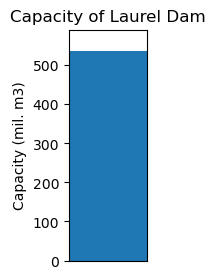

In [25]:
# read the bounding box of the study area
res_names = RESERVOIRS_GDF[['id', 'name']].set_index('id').to_dict()['name'] # dictionary that can be queried to get reservoir name

RESERVOIR_NAME = res_names[RESERVOIR]

RESERVOIR_GDF = RESERVOIRS_GDF.loc[RESERVOIRS_GDF['id'] == RESERVOIR]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = np.nan if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)
print(f"Areas: {min_area = }, {nominal_area = :.2f}, {max_area = }, {area_rep = :.2f}")
print(f"")

# what is the reported capacity?
f, ax = plt.subplots(figsize=(1,3))

ax.axhspan(0, capacity)
ax.set_ylim(0, capacity*1.1)
ax.set_xticks([])
ax.set_ylabel('Capacity (mil. m3)')
ax.set_title(f'Capacity of {RESERVOIR_NAME.replace("_", " ")}')

## Helper functions

In [26]:
def get_insitu_observed_data(
        id, 
        RESERVOIRS_GDF, 
        src_dir = Path('/tiger1/pdas47/resorr-swot/data/insitu/resops')
    ):
    row = RESERVOIRS_GDF[RESERVOIRS_GDF['id'] == id]
    name = row['name'].values[0]
    src_dir = Path(src_dir)
    src = src_dir.name

    if src == 'resops':
        src_fn = src_dir / f'{name}.csv'
        insitu_df = pd.read_csv(src_fn)
    elif src =='usace':
        name_without_dam = name.replace('_Dam', '')
        elevation_src_fn = src_dir / f'{name_without_dam}-elevation'
        inflow_src_fn = src_dir / f'{name_without_dam}-inflow'
        outflow_src_fn = src_dir / f'{name_without_dam}-outflow'
        storage_src_fn = src_dir / f'{name_without_dam}-storage'

        elevation_df = pd.read_csv(elevation_src_fn, comment='#', names=['time', 'elevation'], index_col=0)
        elevation_df.index = pd.to_datetime(elevation_df.index)
        inflow_df = pd.read_csv(inflow_src_fn, comment='#', names=['time', 'inflow'], index_col=0)
        inflow_df.index = pd.to_datetime(inflow_df.index)
        outflow_df = pd.read_csv(outflow_src_fn, comment='#', names=['time', 'outflow'], index_col=0)
        outflow_df.index = pd.to_datetime(outflow_df.index)
        storage_df = pd.read_csv(storage_src_fn, comment='#', names=['time', 'storage'], index_col=0)
        storage_df.index = pd.to_datetime(storage_df.index)

        insitu_df = pd.concat([elevation_df, inflow_df, outflow_df, storage_df], axis=1)
        # insitu data is in hourly time format
        insitu_df = insitu_df.resample('1D').median()
        # convert from imperial to SI
        insitu_df['elevation'] = insitu_df['elevation'] * 0.3048
        insitu_df['inflow'] = insitu_df['inflow'] * 0.028316847
        insitu_df['outflow'] = insitu_df['outflow'] * 0.028316847
        insitu_df['storage'] = insitu_df['storage'] * 1233.48


    return insitu_df

In [27]:
observed_df = get_insitu_observed_data(RESERVOIR, RESERVOIRS_GDF, obs_dir_fn)
observed_df = observed_df[observed_df['storage'] > 0]  # clean 
observed_df.head()

,elevation,inflow,outflow,storage
time,,,,
2019-01-01 00:00:00+00:00,309.660,101.090001,100.665001,5.184378e+08
2019-01-02 00:00:00+00:00,309.630,61.230001,101.090001,5.177100e+08
2019-01-03 00:00:00+00:00,309.500,42.140001,101.800001,5.145807e+08
2019-01-04 00:00:00+00:00,309.425,40.430001,75.180001,5.127977e+08
2019-01-05 00:00:00+00:00,309.400,80.860001,0.000000,5.121791e+08


<Axes: xlabel='elevation', ylabel='storage'>

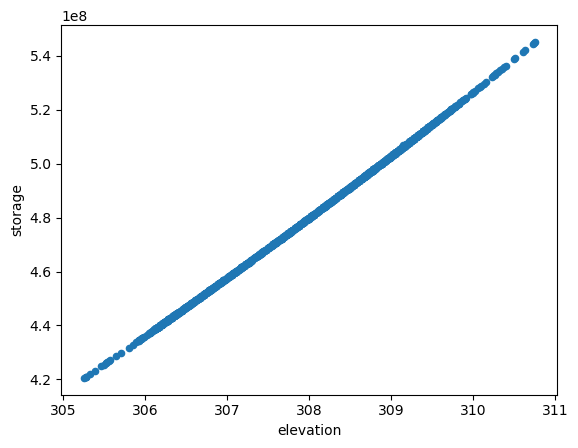

In [28]:
f, ax = plt.subplots()

observed_df.plot(
    ax=ax,
    kind='scatter',
    x='elevation',
    y='storage',
)

## Fit a 2° polynomial to Elevation-Storage

Text(0.5, 1.0, 'Elevation-Storage for Laurel Dam')

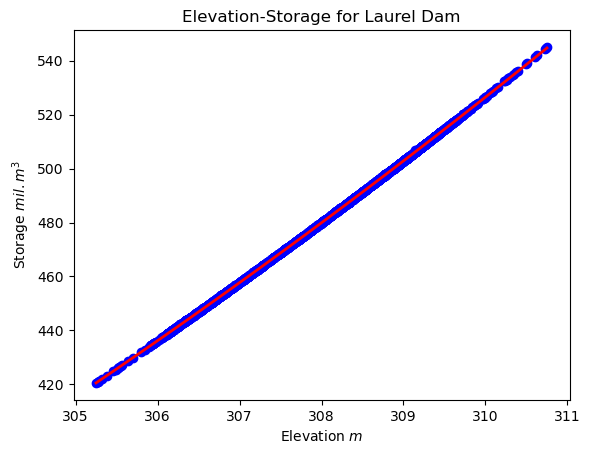

In [29]:
# Fit a 2-degree polynomial
coefficients = np.polyfit(observed_df['elevation'], observed_df['storage'], 2)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial
x_values = np.linspace(observed_df['elevation'].min(), observed_df['elevation'].max(), 100)
y_values = polynomial(x_values)

f, ax = plt.subplots()
ax.scatter(
    x = observed_df['elevation'],
    y = observed_df['storage'] * 1e-6,
    color = 'blue'
)
ax.add_line(
    plt.Line2D(
        xdata = x_values,
        ydata = y_values * 1e-6,
        color='red',
        lw=2
    )
)
ax.set_xlabel('Elevation $m$')
ax.set_ylabel('Storage $mil. m^3$')
ax.set_title(f'Elevation-Storage for {RESERVOIR_NAME.replace("_"," ")}')

In [30]:
# Fit polynomial curves to predict storage from elevation and area
coefficients_elevation = np.polyfit(observed_df['elevation'], observed_df['storage'], 2)
polynomial_elevation = np.poly1d(coefficients_elevation)

# Generate equally spaced elevation values
min_elevation = np.floor(observed_df['elevation'].min() / 0.25) * 0.25
max_elevation = np.ceil(observed_df['elevation'].max() / 0.25) * 0.25
elevation_values = np.arange(min_elevation, max_elevation + 0.25, 0.25)

# Predict storage values using the polynomial functions
predicted_storage_elevation = polynomial_elevation(elevation_values)

# Interpolate the observed storage using linear interpolation for the elevation_values
observed_storage_interpolated = np.interp(elevation_values, observed_df['elevation'], observed_df['storage'])

# Create a dataframe with the predicted storage, interpolated observed storage, and elevation values
predicted_df = pd.DataFrame({
    'Elevation': elevation_values,
    'Storage (mil. m3)': predicted_storage_elevation,
})

polynomial_elevation # x2, x, s₀

poly1d([ 3.56884562e+05, -1.97261761e+08,  2.73810400e+10])

## Adding Area to AEV.

Methodology:
1. Create a relationship between min-max Area and min-max Elevation (in-situ observed).
2. Create a polynomial function to convert between the two. Then generate Area-Storage curves.

In [31]:
sat_files = sat_inp_dir.glob("*.csv")
scores = []
for fp in sat_files:
    stem = fp.stem
    # remove leading numeric ID if present (e.g. "1752.0_Barkley_Dam" -> "Barkley_Dam")
    parts = stem.split('_')
    if parts and any(ch.isdigit() for ch in parts[0]):
        cleaned = '_'.join(parts[1:]) or stem
    else:
        cleaned = stem

    r1 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), stem.lower()).ratio()
    r2 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), cleaned.lower()).ratio()
    score = max(r1, r2)
    scores.append((fp, stem, cleaned, score))

best_fp, best_stem, best_clean, best_score = max(scores, key=lambda x: x[3])
selected = best_fp
print(f"selected: {selected} (score={best_score:.3f}, stem='{best_stem}', cleaned='{best_clean}')")
fp = best_fp

sat_df = pd.read_csv(fp, parse_dates=['date'])

sat_df.head()

selected: /tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos/1754.0_Laurel_Dam.csv (score=1.000, stem='1754.0_Laurel_Dam', cleaned='Laurel_Dam')


,date,water_area_uncorrected,non_water_area,cloud_area,unfiltered_area,cloud_percent,QUALITY_DESCRIPTION,sat,filtered_area,corrected_areas_1,corrected_trend_1,sar_trend,days_passed,area
0,2022-06-08,1.110944,7.997227,78.932114,22.682921,89.654542,0.0,s2,22.682921,21.317264,-0.046631,-0.018359,5.0,21.317264
1,2022-06-13,12.661219,29.944610,45.434455,21.317264,51.606439,0.0,s2,21.317264,21.317264,-0.273131,-0.022949,5.0,21.317264
2,2022-06-18,22.616604,64.774783,0.648898,22.892375,0.737047,0.0,s2,22.892375,22.892375,0.315022,-0.017175,5.0,22.892375
3,2022-06-19,9.534519,39.355199,39.129751,NaN,44.455791,0.0,l9,NaN,NaN,NaN,-0.008514,1.0,22.883861
4,2022-06-23,22.664654,65.404992,-0.029361,22.664973,-0.033350,0.0,s2,22.664973,22.664973,-0.045480,-0.008514,4.0,22.664973


In [32]:
# fit a polynomial function to area-elevation data points. Constrain to a monotonically increasing polynomial
# Build combined_sorted by matching in-situ elevation and satellite area on dates
obs = observed_df.copy()
if getattr(obs.index, 'tz', None) is not None:
    obs_index = obs.index.tz_convert(None)
else:
    obs_index = obs.index
obs_elev = pd.Series(obs['elevation'].values, index=obs_index, name='elevation')

sat = sat_df.copy()
sat['date'] = pd.to_datetime(sat['date'])
sat_area = sat.set_index('date')['area'].rename('area')

# align, drop unmatched, and sort
combined_sorted = pd.concat([obs_elev, sat_area], axis=1).dropna().sort_index()

# compute day-to-day deltas (can be negative)
deltas = combined_sorted.diff().dropna()

# Ensure datetime index is tz-naive and ready for holoviews
combined_sorted = combined_sorted.copy()
combined_sorted.index = pd.to_datetime(combined_sorted.index)

deltas = deltas.copy()
deltas.index = pd.to_datetime(deltas.index)

df = combined_sorted.reset_index().rename(columns={'index': 'date'})

# DEG = 2
# X = df['elevation'].values.reshape([-1, 1])
# y = df['area'].values
# x_values = np.linspace(df['elevation'].min(), df['elevation'].max(), 100)

# polyestimator = PolynomRegressor(deg=DEG)
# monotone_constraint = Constraints(monotonicity='inc')
# polyestimator.fit(X, y, loss = 'l2', constraints={0: monotone_constraint}, verbose=True)
# pred_mon = polyestimator.predict(x_values.reshape(-1, 1))
# polyestimator.coeffs_

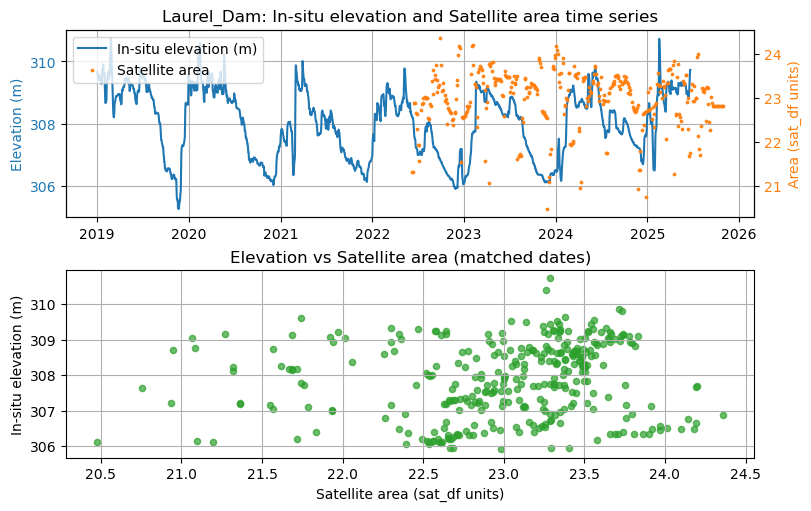

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)

# time series: elevation (left y) and area (right y)
ax1 = axes[0]
ax1.plot(obs_elev.index, obs_elev.values, color='tab:blue', label='In-situ elevation (m)')
ax1.set_ylabel('Elevation (m)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1_twin = ax1.twinx()
ax1_twin.scatter(sat_area.index, sat_area.values, color='tab:orange', alpha=0.9, s=3, label='Satellite area')
ax1_twin.set_ylabel('Area (sat_df units)', color='tab:orange')
ax1_twin.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_title(f'{RESERVOIR_NAME}: In-situ elevation and Satellite area time series')
ax1.grid(True)
# combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# scatter: area vs elevation (match by date)
combined = pd.concat([obs_elev, sat_area], axis=1).dropna()
ax2 = axes[1]
ax2.scatter(combined['area'], combined['elevation'], s=20, alpha=0.7, color='tab:green')
ax2.set_xlabel('Satellite area (sat_df units)')
ax2.set_ylabel('In-situ elevation (m)')
ax2.set_title('Elevation vs Satellite area (matched dates)')
ax2.grid(True)

plt.show()

In [13]:
DEG = 2
BINSIZE = 1

In [14]:
# IQR based filtering function

def remove_outliers_iqr(group, iqr_multiplier=1.5):
    q1 = group['area'].quantile(0.25)
    q3 = group['area'].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr_multiplier * iqr)
    upper_bound = q3 + (iqr_multiplier * iqr)
    
    return group[(group['area'] >= lower_bound) & (group['area'] <= upper_bound)]

/tmp/ipykernel_3711158/404880745.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('bin', observed=True).apply(remove_outliers_iqr).reset_index(drop=True)
(CVXPY) Jan 22 11:27:52 PM: Your problem has 3 variables, 20 constraints, and 0 parameters.
(CVXPY) Jan 22 11:27:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 11:27:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 11:27:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 22 11:27:52 PM: Your problem is compiled with the CPP canonicalization backend.

305.25 311.0 [305.25 306.25 307.25 308.25 309.25 310.25 311.25 312.25]
                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 299, constraints m = 316
          

Text(0.5, 1.0, 'Elevation-Area relation for Laurel Dam')

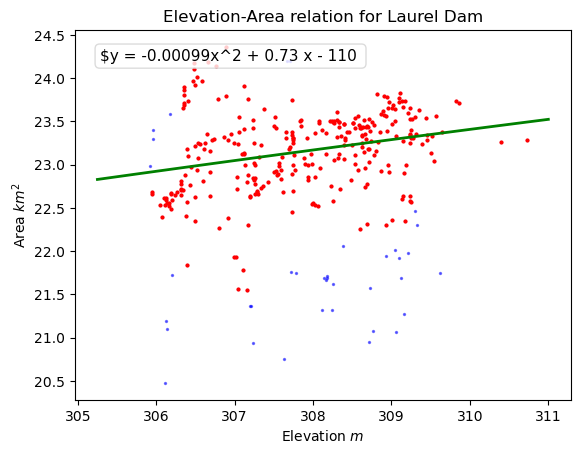

In [34]:
x_values = np.linspace(predicted_df['Elevation'].min(), predicted_df['Elevation'].max(), 100)

# 2. Define bins
min_val, max_val = predicted_df['Elevation'].min(), predicted_df['Elevation'].max()
bins = np.arange(min_val, max_val + 2*BINSIZE, BINSIZE)

print(min_val, max_val, bins)

# Assign each row to a bin
df['bin'] = pd.cut(df['elevation'], bins=bins, include_lowest=True)

# Apply the filter and drop the helper 'bin' column
filtered_df = df.groupby('bin', observed=True).apply(remove_outliers_iqr).reset_index(drop=True)

X = filtered_df['elevation'].values.reshape([-1, 1])
y = filtered_df['area'].values
polyestimator_filtered = PolynomRegressor(deg=DEG)
monotone_constraint = Constraints(monotonicity='inc', constraint_range = (min_val, max_val))
polyestimator_filtered.fit(X, y, loss = 'l2', constraints={0: monotone_constraint}, verbose=True)
# pred_mon_filtered = polyestimator_filtered.predict(x_values.reshape(-1, 1))
X_vander = np.vander(x_values, DEG + 1, increasing=True)
pred_mon_filtered = np.dot(X_vander, polyestimator_filtered.coeffs_)

def format_decimal_sig_figs(val, n=2):
    """
    Formats a number as a decimal string with n significant figures,
    ensuring no scientific notation is used.
    """
    if val == 0:
        return "0"
    
    # Format to n significant figures using 'g', then convert to Decimal 
    # to strip scientific notation and trailing zeros.
    formatted = f"{val:.{n}g}"
    decimal_val = Decimal(formatted)
    
    # '{:f}'.format(decimal_val) prevents scientific notation for small floats
    return '{:f}'.format(decimal_val.normalize())

# 1. Extract coefficients
coeffs = polyestimator_filtered.coeffs_  # [intercept, linear, quadratic]
print(coeffs)

# 2. Build the equation components
# a*x^2 + b*x + c
a_val = coeffs[2]
b_val = coeffs[1]
c_val = coeffs[0]

# Helper to handle the sign and formatting for b and c terms
def get_term(value, variable_str=""):
    sign = "+ " if value >= 0 else "- "
    return f"{sign}{format_decimal_sig_figs(abs(value))} {variable_str}"

equation_text = (
    rf"$y = {format_decimal_sig_figs(a_val)}x^2 "
    rf"{get_term(b_val, 'x')} "
    rf"{get_term(c_val)}$"
)

print(equation_text)

f, ax = plt.subplots()
ax.scatter(
    x = df['elevation'],
    y = df['area'],
    color = 'blue',
    alpha=0.5,
    s=2
)
ax.scatter(
    x = filtered_df['elevation'],
    y = filtered_df['area'],
    color = 'red',
    s=4,
    alpha=1,
)
ax.add_line(
    plt.Line2D(
        xdata = x_values,
        ydata = pred_mon_filtered,
        color='green',
        lw=2
    )
)


ax.text(0.05, 0.95, equation_text, 
        transform=ax.transAxes, 
        fontsize=11,
        verticalalignment='top', 
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='lightgray'))

ax.set_xlabel('Elevation $m$')
ax.set_ylabel('Area $km^2$')

ax.set_title(f'Elevation-Area relation for {RESERVOIR_NAME.replace("_"," ")}')

In [35]:
# insert area in the area-elevation curve
aev_area = polyestimator_filtered.predict(predicted_df['Elevation'].values.reshape(-1, 1))
predicted_df['Area'] = aev_area
predicted_df.head()

,Elevation,Storage (mil. m3),Area
0,305.25,4.205211e+08,22.829346
1,305.50,4.256974e+08,22.860916
2,305.75,4.309184e+08,22.892363
3,306.00,4.361840e+08,22.923687
4,306.25,4.414942e+08,22.954887


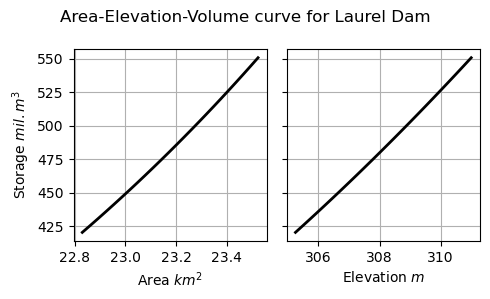

In [36]:
f, ax = plt.subplots(ncols=2, figsize=(5, 3), sharey=True)
ax[0].plot(
    predicted_df['Area'],
    predicted_df['Storage (mil. m3)']*1e-6,
    color='k',
    lw=2
)
ax[1].plot(
    predicted_df['Elevation'],
    predicted_df['Storage (mil. m3)']*1e-6,
    color='k',
    lw=2
)
ax[0].set_xlabel('Area $km^2$')
ax[1].set_xlabel('Elevation $m$')
ax[0].set_ylabel('Storage $mil. m^3$')
ax[0].grid()
ax[1].grid()
f.suptitle(f'Area-Elevation-Volume curve for {RESERVOIR_NAME.replace("_", " ")}')
f.tight_layout()

Now using these AEV relationships, we can calculate the storage time series of the dam of interest.

# Storage estimation

In [37]:
aec_df = predicted_df
aec_df.head()

,Elevation,Storage (mil. m3),Area
0,305.25,4.205211e+08,22.829346
1,305.50,4.256974e+08,22.860916
2,305.75,4.309184e+08,22.892363
3,306.00,4.361840e+08,22.923687
4,306.25,4.414942e+08,22.954887


In [38]:
sat_df
data = {
    'area': [],
    'date': [],
}

data['area'] = sat_df['area']
data['date'] = sat_df['date']
data['storage'] = np.interp(data['area'], aec_df['Area'], aec_df['Storage (mil. m3)'])

reservoir_dynamics = pd.DataFrame(data)
reservoir_dynamics = reservoir_dynamics.dropna()
reservoir_dynamics['storage_change'] = reservoir_dynamics['storage'].diff()
reservoir_dynamics['delta_t'] = reservoir_dynamics['date'].diff().dt.days
reservoir_dynamics.head()

,area,date,storage,storage_change,delta_t
0,21.317264,2022-06-08,4.205211e+08,NaN,NaN
1,21.317264,2022-06-13,4.205211e+08,0.000000e+00,5.0
2,22.892375,2022-06-18,4.309204e+08,1.039933e+07,5.0
3,22.883861,2022-06-19,4.295069e+08,-1.413552e+06,1.0
4,22.664973,2022-06-23,4.205211e+08,-8.985776e+06,4.0


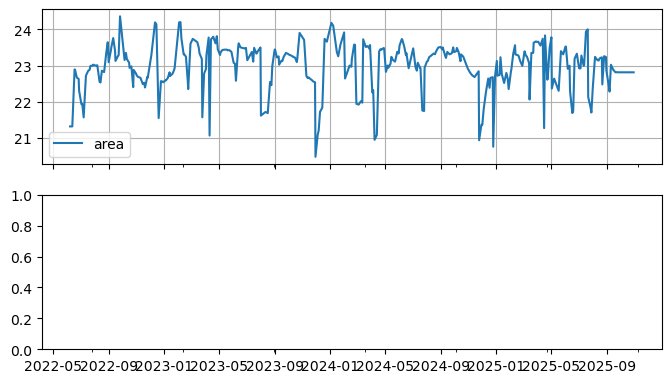

In [39]:
f, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

reservoir_dynamics.plot(
    x='date', y='area', ax=ax[0]
)

ax[0].grid()


537300000.0


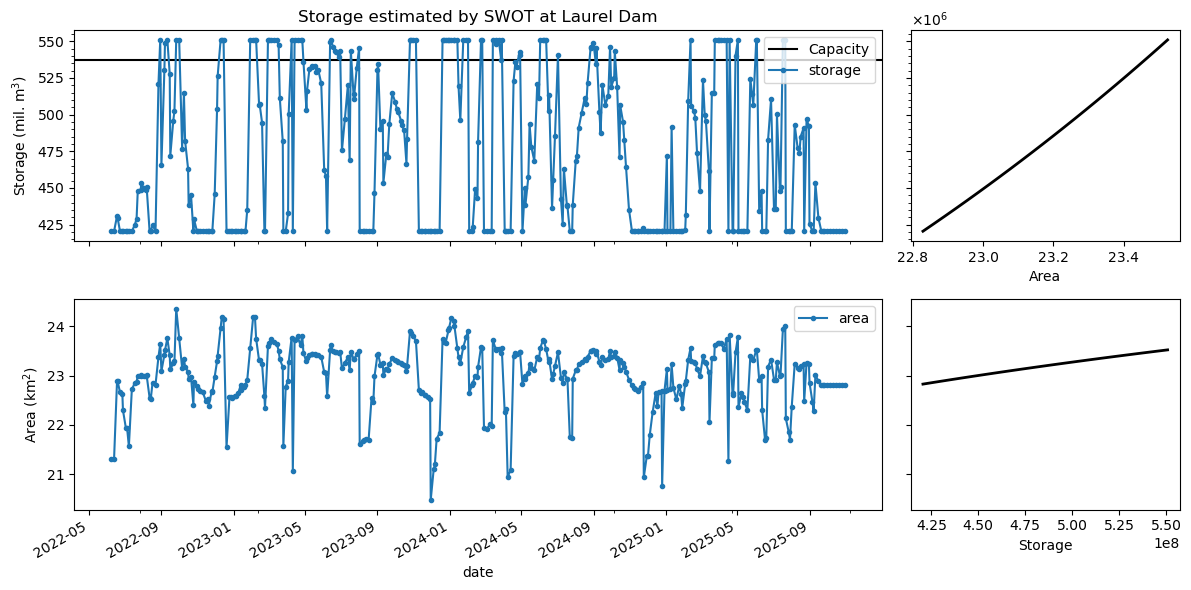

In [40]:
from matplotlib import ticker

print(capacity * 1e6)

f, ax = plt.subplots(figsize=(12, 6))
ax.axis(False)

# 2. Define the grid (2 rows, 2 columns) with width ratios
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])

# 3. Create the individual subplots with specific sharing
# Top Left (The anchor)
ax_top_left = f.add_subplot(gs[0, 0])
# Top Right: Shares Y with Top Left
ax_top_right = f.add_subplot(gs[0, 1], sharey=ax_top_left)
# Bottom Left: Shares X with Top Left
ax_bottom_left = f.add_subplot(gs[1, 0], sharex=ax_top_left)
# Bottom Right: Independent
ax_bottom_right = f.add_subplot(gs[1, 1], sharey=ax_bottom_left)

if RESERVOIR_NAME == 'Old_Hickory_Dam':
    PERMANENT_POOL_VOL = 440352360
    PONDAGE_ALLOWED_FOR_POWER = 77709240
    SURCHARGE_FLOOD_STORE_VOL = 154185000

    ax_top_left.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER + SURCHARGE_FLOOD_STORE_VOL, color='lightgreen', label='Flood surcharge storage')
    ax_top_left.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER, color='Olive', label='Pondage allowed for power')
    ax_top_left.axhline(PERMANENT_POOL_VOL, color='Green', label='Permanent Pool')
else:
    ax_top_left.axhline(capacity * 1e6, label='Capacity', color='black')


reservoir_dynamics.plot(
    ax=ax_top_left,
    x='date',
    y='storage',
    marker='.'
)
reservoir_dynamics.plot(
    ax=ax_bottom_left,
    x='date',
    y='area',
    marker='.'
)
ax_top_right.plot(
    aec_df['Area'],
    aec_df['Storage (mil. m3)'],
    color='k',
    lw=2
)
ax_bottom_right.plot(
    aec_df['Storage (mil. m3)'], # it is not mil. m3, it is just m3
    aec_df['Area'],
    color='k', lw=2
)

ax_top_left.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useOffset=False, useMathText=True)
offset_text_artist = ax_top_left.yaxis.get_offset_text()
offset_text_artist.set_visible(False) # removing the x10^6 from plot. Specifying the unit in label.
ax_top_left.set_ylabel('Storage (mil. m$^3$)')
ax_top_left.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_top_left.set_title(f'Storage estimated by SWOT at {RESERVOIR_NAME.replace("_", " ")}')
ax_top_left.legend()
ax_bottom_left.set_ylabel('Area (km$^2$)')
ax_bottom_right.set_xlabel('Storage')
ax_top_right.set_xlabel('Area')
f.tight_layout()